# San Francisco Crime Classification

### Data fields

- Dates - timestamp of the crime incident
- Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import folium

### Importing datasets

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### Train dataset

In [3]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
train_df.shape

(878049, 9)

In [5]:
train_df.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


**Note:**

Max. Y = 90, it can be some outlier

Y = 90, point is on the top of map, there is nothing

In [6]:
train_df[train_df['Y'] ==90.0]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5,90.0
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5,90.0
...,...,...,...,...,...,...,...,...,...
844995,2003-06-11 08:49:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0
845842,2003-06-09 09:25:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0
852880,2003-05-02 01:00:00,SEX OFFENSES FORCIBLE,"FORCIBLE RAPE, BODILY FORCE",Friday,SOUTHERN,COMPLAINANT REFUSES TO PROSECUTE,3RD ST / JAMES LICK FREEWAY HY,-120.5,90.0
857248,2003-04-14 16:30:00,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Monday,BAYVIEW,COMPLAINANT REFUSES TO PROSECUTE,GILMAN AV / FITCH ST,-120.5,90.0


In [7]:
train_df.describe(include=['O'])

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,878049,878049,878049,878049,878049,878049,878049
unique,389257,39,879,7,10,17,23228
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,185,174900,60022,133734,157182,526790,26533


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


**Note:**

We don't have any null values in our train dataset

In [9]:
target = train_df["Category"].unique()
print(target)

['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']


**Note:** 
There are multiple categorical values. It's multi class classification problem

### Test dataset

In [10]:
test_df.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [11]:
test_df.shape

(884262, 7)

**Note:**

Test dataset doesn't have Category, Descript and Resolution columns

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null object
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB


**Note:**

We don't have any null values in our train dataset

## Analysis

How many crimes are there per category?

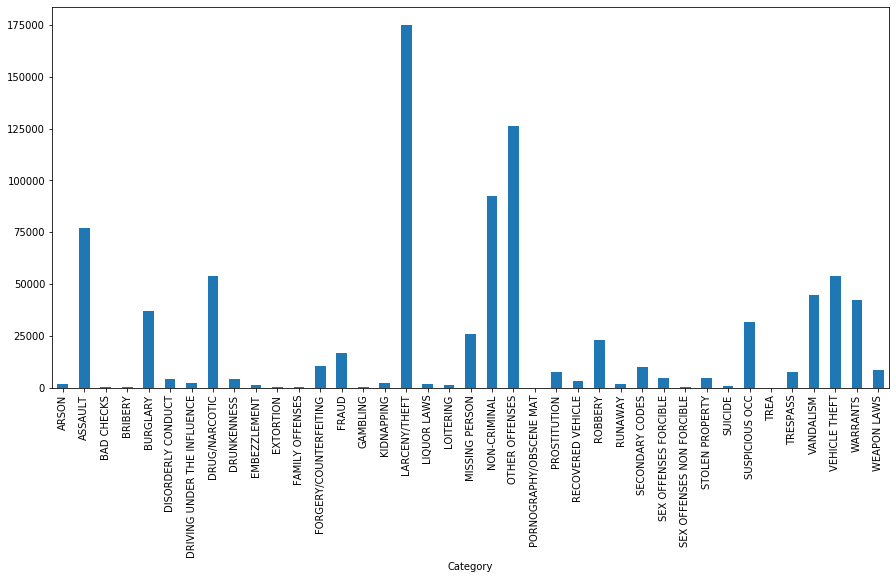

In [13]:
df_category = train_df.groupby(['Category'])['Dates'].count()
df_category.plot(kind='bar',figsize=(15,7))

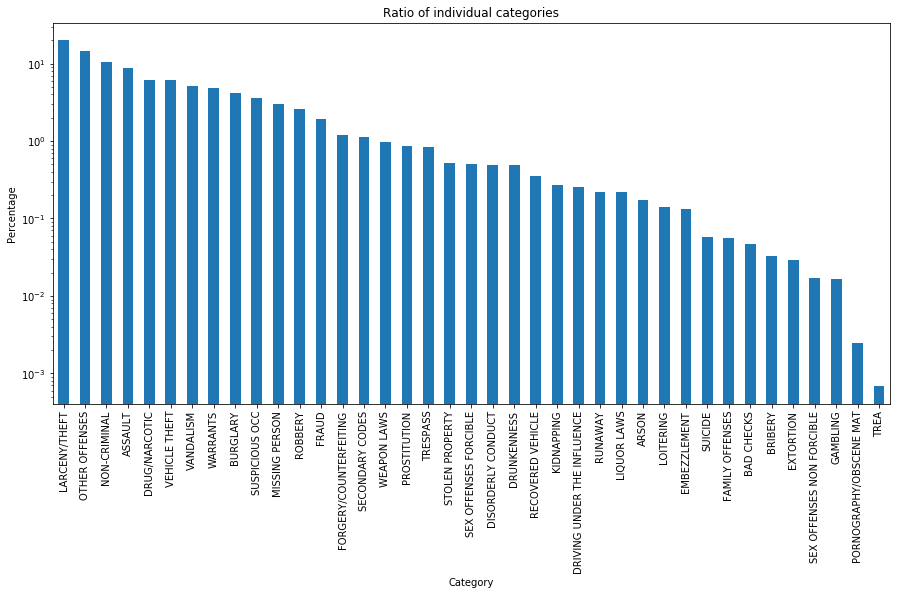

In [14]:
df_cat_percentage = (df_category/df_category.sum()*100).sort_values(ascending=False)
title = "Ratio of individual categories"
plt.figure()
df_cat_percentage.plot(kind='bar',figsize=(15,7), title=title, logy=True)
plt.ylabel('Percentage')
plt.show()

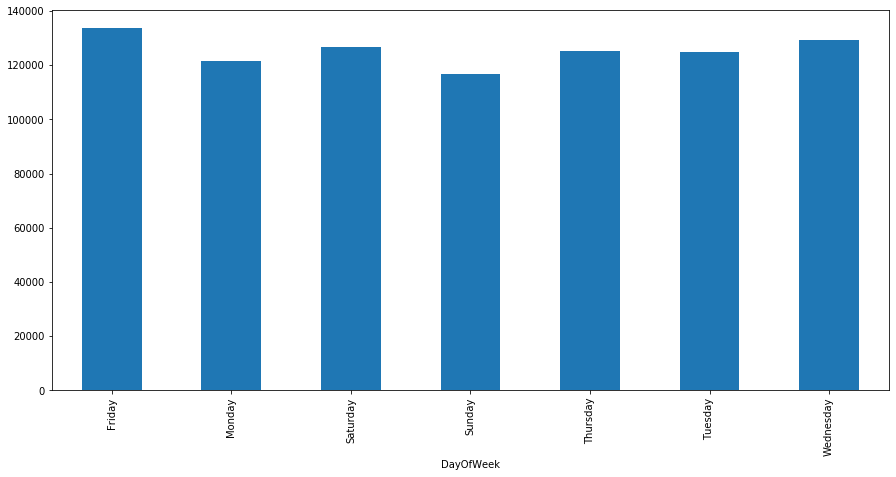

In [15]:
df_dayOfWeek = train_df.groupby(['DayOfWeek'])['Dates'].count()
df_dayOfWeek.plot(kind='bar',figsize=(15,7))

**Note:**

There is a similar number of crimes each day of the week

### Extract part of day from *Dates* column

- 02:00-06:00 is **Dawn**
- 06:00-10:00 is **Morning**
- 10:00-14:00 is **Noon**
- 14:00-18:00 is **After noon**
- 18:00-22:00 is **Evening**
- 22:00-02:00 is **Night**

In [16]:
train_df['Dates'] = pd.to_datetime(train_df['Dates'])

#### Define function which tells which part of the day is it

In [17]:
hour_2 = pd.to_datetime('2:00:00').time()
hour_6 = pd.to_datetime('6:00:00').time()
hour_10 = pd.to_datetime('10:00:00').time()
hour_14 = pd.to_datetime('14:00:00').time()
hour_18 = pd.to_datetime('18:00:00').time()
hour_22 = pd.to_datetime('22:00:00').time()
def get_part_of_day(time):
    return (
        "Dawn" if hour_2 <= time < hour_6
        else
        "Morning" if hour_6 <= time < hour_10
        else
        "Noon" if hour_10 <= time < hour_14
        else
        "After Noon" if hour_14 <= time < hour_18
        else
        "Evening" if hour_18 <= time < hour_22
        else 
        "Night"
    )

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


In [19]:
train_df['PartOfDay'] = train_df['Dates'].dt.time.apply(get_part_of_day)

In [20]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PartOfDay
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,Night
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,Night
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,Night


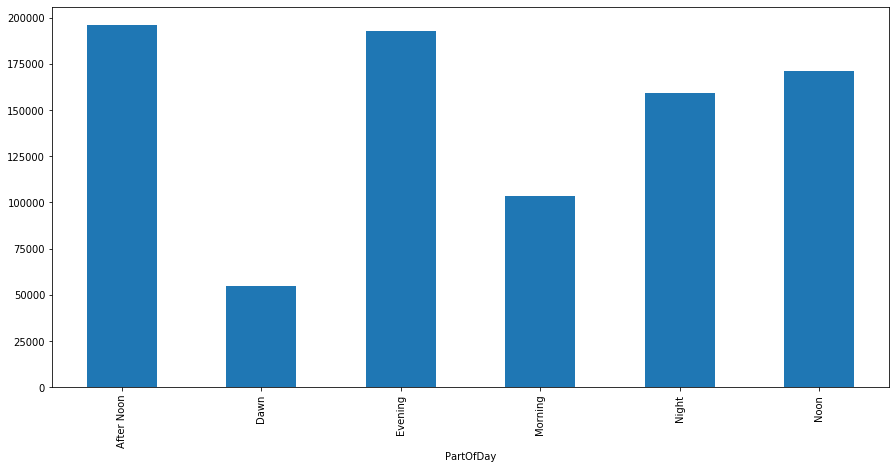

In [21]:
df_partOfDay = train_df.groupby(['PartOfDay'])['Dates'].count()
df_partOfDay.plot(kind='bar',figsize=(15,7))

**Note:**

We can see that the most crimes are comitted between 10:00 and 2:00.

In [22]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PartOfDay
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,Night
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,Night
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,Night


### Multiple crimes or group crime?

As we can see above, crimes 0 and 1 occured at the same time in the same location. Group crime or multiple crimes?

1     550477
2      97879
3      34002
4       4358
5       1392
6        467
7        165
8         80
9         39
10        18
11        11
12         6
13         5
16         1
14         1
dtype: int64

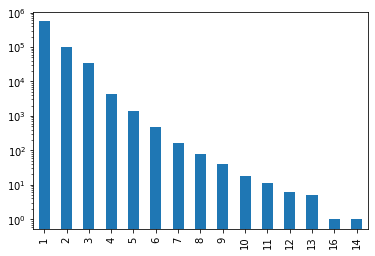

In [23]:
df_multiple_crimes = train_df.groupby(['Dates','X','Y']).size()
df_multiple_crimes.value_counts().plot('bar', logy=True)
df_multiple_crimes.value_counts()

As we can see it occurs not so rarely. 

In [24]:
other = pd.DataFrame(df_multiple_crimes[df_multiple_crimes>=12])
other = other.reset_index()
multiplearrest = train_df.merge(other, how='right')

In [25]:
multiplearrest[multiplearrest[0]==16]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PartOfDay,0
13,2013-10-18 15:00:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Friday,TENDERLOIN,NONE,0 Block of POWELL ST,-122.407845,37.785094,After Noon,16
14,2013-10-18 15:00:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Friday,TENDERLOIN,NONE,0 Block of POWELL ST,-122.407845,37.785094,After Noon,16
15,2013-10-18 15:00:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Friday,TENDERLOIN,NONE,0 Block of POWELL ST,-122.407845,37.785094,After Noon,16
16,2013-10-18 15:00:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Friday,TENDERLOIN,NONE,0 Block of POWELL ST,-122.407845,37.785094,After Noon,16
17,2013-10-18 15:00:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Friday,TENDERLOIN,NONE,0 Block of POWELL ST,-122.407845,37.785094,After Noon,16
18,2013-10-18 15:00:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Friday,TENDERLOIN,NONE,0 Block of POWELL ST,-122.407845,37.785094,After Noon,16
19,2013-10-18 15:00:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Friday,TENDERLOIN,NONE,0 Block of POWELL ST,-122.407845,37.785094,After Noon,16
20,2013-10-18 15:00:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Friday,TENDERLOIN,NONE,0 Block of POWELL ST,-122.407845,37.785094,After Noon,16
21,2013-10-18 15:00:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Friday,TENDERLOIN,NONE,0 Block of POWELL ST,-122.407845,37.785094,After Noon,16
22,2013-10-18 15:00:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Friday,TENDERLOIN,NONE,0 Block of POWELL ST,-122.407845,37.785094,After Noon,16


This case seems to correspond to 16 arrest for one crime. Maybe due to protests?

In [26]:
multiplearrest[multiplearrest[0]==14]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PartOfDay,0
66,2010-04-10 22:15:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Saturday,RICHMOND,"ARREST, BOOKED",2700 Block of MCALLISTER ST,-122.457483,37.775413,Night,14
67,2010-04-10 22:15:00,OTHER OFFENSES,CONSPIRACY,Saturday,RICHMOND,"ARREST, BOOKED",2700 Block of MCALLISTER ST,-122.457483,37.775413,Night,14
68,2010-04-10 22:15:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Saturday,RICHMOND,"ARREST, BOOKED",2700 Block of MCALLISTER ST,-122.457483,37.775413,Night,14
69,2010-04-10 22:15:00,OTHER OFFENSES,CONSPIRACY,Saturday,RICHMOND,"ARREST, BOOKED",2700 Block of MCALLISTER ST,-122.457483,37.775413,Night,14
70,2010-04-10 22:15:00,OTHER OFFENSES,CONSPIRACY,Saturday,RICHMOND,"ARREST, BOOKED",2700 Block of MCALLISTER ST,-122.457483,37.775413,Night,14
71,2010-04-10 22:15:00,OTHER OFFENSES,CONSPIRACY,Saturday,RICHMOND,"ARREST, BOOKED",2700 Block of MCALLISTER ST,-122.457483,37.775413,Night,14
72,2010-04-10 22:15:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Saturday,RICHMOND,"ARREST, BOOKED",2700 Block of MCALLISTER ST,-122.457483,37.775413,Night,14
73,2010-04-10 22:15:00,OTHER OFFENSES,CONSPIRACY,Saturday,RICHMOND,"ARREST, BOOKED",2700 Block of MCALLISTER ST,-122.457483,37.775413,Night,14
74,2010-04-10 22:15:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Saturday,RICHMOND,"ARREST, BOOKED",2700 Block of MCALLISTER ST,-122.457483,37.775413,Night,14
75,2010-04-10 22:15:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Saturday,RICHMOND,"ARREST, BOOKED",2700 Block of MCALLISTER ST,-122.457483,37.775413,Night,14


This case seems to correspond to 7 arrests for 2 different crime categories (VANDALISM and CONSPIRACY)

### Which District is the most dangerous

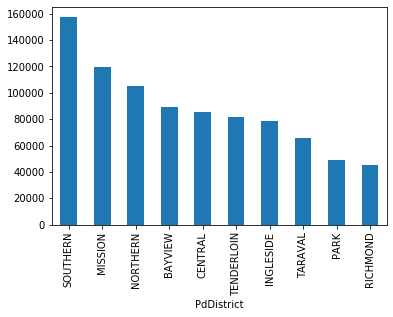

In [27]:
train_df.groupby(['PdDistrict'])['Dates'].count().sort_values(ascending=False).plot(kind='bar')

SOUTHERN DISTRICT is most dangerous

Let's visualize it!

In [28]:
crime_district_count = pd.DataFrame(train_df.groupby(['PdDistrict'])['Dates'].count())
crime_district_count.reset_index(inplace=True)

In [29]:
latitude = 37.77
longitude = -122.42
sf_districts = f'data/sfpddistricts.geojson'

sf_map = folium.Map(
       location=[latitude,longitude],
       zoom_start=12)

sf_map.choropleth(
        geo_data=sf_districts,
        data=crime_district_count,
        columns=['PdDistrict','Dates'],
        key_on='feature.properties.DISTRICT',
        fill_color='YlOrRd',
        fill_opacity='0.7',
        line_opacity='0.2',
        legend_name='Crime Rate in San Francisco, by District')

sf_map

### How did number of crimes look each year

In [36]:
train_df['Year'] = train_df['Dates'].apply(lambda x : '{year}'.format(year=x.year))

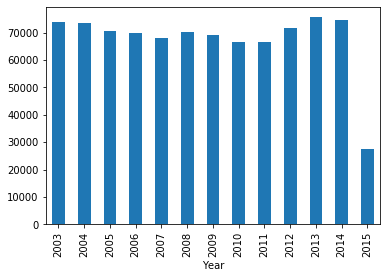

In [40]:
train_df.groupby('Year')['Dates'].count().plot(kind='bar')

Each year number of crimes was similar. 2015 is different, because of data ranges 1/1/2013 to 5/13/2015